In [2]:
#Some packages needs to be installed in order to run this code
#Moving Pandas is the most complicated to install
#Get anaconda - create new environment


import numpy as np
import json

import pandas as pd      #Package for handling large data structures
import geopandas as gpd  #http://localhost:8888/notebooks/KTH/GitHub/DF23_cycle/M_stat_all.ipynb#Package for handling geospatial data

#import requests
import geojson
from pyproj import CRS
#from owslib.wms import WebMapService
#from owslib.wcs import WebCoverageService

import scipy.stats as stats
from scipy.signal import lfilter

import random

#Packages for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Packages for interpreting elevation data
from scipy.spatial import cKDTree
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator

#MovingPandas (Kalman-filter)
import movingpandas as mpd

import hvplot.pandas 
import matplotlib.pyplot as plt

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, shape
from shapely import wkt  #If the geo_data is in wkt-format, this package is needed to "read" that (wtk - well known text)
import shapely as shp

from datetime import datetime, timedelta
from holoviews import opts, dim

import time

import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom']))
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':320, 'frame_width':320, 'cmap':'Viridis', 'colorbar':True}

import pickle

import matplotlib.colors as colors
from mycolorpy import colorlist as mcp

# Welcome to my notebook
Here we will process bicycle-data (GPS) and try to do some statistics to it.

In [2]:
#Read data into panda
df = pd.read_json(r"trip5000.json")

## Reading the data
The "issue" with geo-data is that it is in a specific format. All geodata-files contain one column with the "geography" of the dataframe. For example it could be:
* Point(1 2) - one coordinate per row
* LineString ((1 2),(2 2),(3 1)) - multiple coordinates in a line
* etc..

GeoPandas handles this type of data really well, but I've realized that when this type of data gets converted to json/csv for saving, there are some issues which can be handled in different ways.

Here we are reading from a json-file and in order to write geodata to json the geodata has to be converted to a "feature", which is why we are reading it like this: first as a dataframe, and then from_features we read it as a geodataframe. Then GeoPandas knows what it's dealing with. 

We will also read from some other formats later, and will go through those when we get to them.

## csr
crs is the coordinate reference system. We want to use the same crs as the original data was projected onto, and this data was projected onto epsg:4617. This is a "degree" based coordinate-system and we will use it throughout (with some minor exeptions)

In [3]:
#Read the data as a geodataframe
gdf = gpd.GeoDataFrame.from_features(df["features"])
gdf = gdf.set_crs('epsg:4617') 

<Axes: >

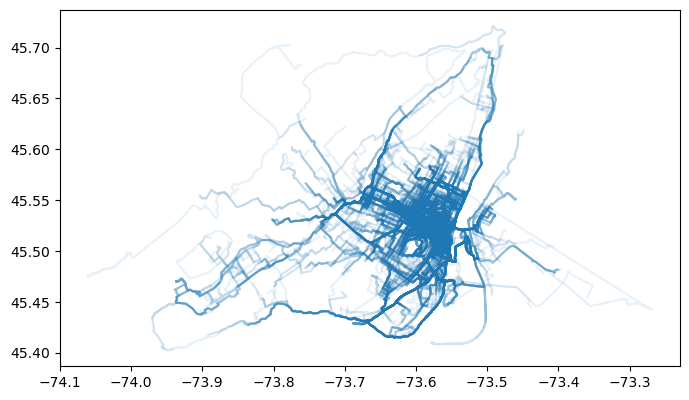

In [4]:
gdf.plot(alpha=0.1,figsize=(8, 8))

In [5]:
gdf.head(3)

,geometry,stop,id_origine,start,length,purpose,liste_segments_jsonb,n_coord,id
0,"LINESTRING (-73.57748 45.50690, -73.57751 45.5...",2013-06-25 16:34:16,52,2013-06-25 16:21:21,3163,Commute,"[{'source': 'GEOBASE', 'id': 1260962}, {'sourc...",511,52
1,"LINESTRING (-73.62897 45.46372, -73.62891 45.4...",2013-07-25 14:40:06,2325,2013-07-25 14:37:42,1066,Courses,"[{'source': 'GEOBASE', 'id': 1310311}, {'sourc...",196,2325
2,"LINESTRING (-73.58481 45.56786, -73.58153 45.5...",2013-07-25 14:43:12,2326,2013-07-25 14:19:15,5619,Courses,"[{'source': 'GEOBASE', 'id': 1170061}, {'sourc...",1036,2326


## Initial process
The data we have is one row per trip. With the coordinates being in the LineString-form mentioned above.
Below we:
* let the computer know that our date/time-data is actually datetime-data
* Calculate the duration of each trip (in seconds) and add that column to the dataframe
* Split each LineString  into a MultiLineString of individual segments: [(a, b, c)] -> [(c,a), (a,b), (b,c)]
* Explode that MultiLineString: 

               1 [(a, b, c)] [data1]  -> [(c,a), (a,b), (b,c)] [data1]
               2 [(d, e, f)] [data2]  -> [(f,d), (d,e), (e,f)] [data2]
               --->
               1 1 [(c,a)]  [data1]
               1 2 [(a,b)]  [data1]
               1 3 [(b,c)]  [data1]
               2 1 [(f,d)]  [data2]
               2 2 [(d,e)]  [data2]
               2 3 [(e,f)]  [data2]

In [8]:
gdf["start"] = pd.to_datetime(gdf['start'])
gdf["stop"] = pd.to_datetime(gdf['stop'])
gdf["duration"] = (gdf['stop'] - gdf['start']) / pd.Timedelta(seconds=1)

In [ ]:
#Here we split each linestring into a multilinestring of individual segments [a, b, c] -> [(c,a), (a,b), (b,c)]
#this also means that the first element needs to be deleted
#It takes like 10 minutes but it is by far the fasted method i've found
gdf["geo"] = gdf.apply(lambda x: MultiLineString([LineString([x['geometry'].coords[i-1], x['geometry'].coords[i]]) for i in range(len(x['geometry'].coords))]),axis=1)


#Make that into the geometry
gdf.set_geometry("geo", drop=False, inplace=True, crs='epsg:4617')
#And explode it based on geo
gdf = gdf.explode(index_parts=True)
gdf.dropna(inplace=True)

## Elevation data
Here we read the elevation data we have, this data is not in a "geometric" shape but instead just one column with latitude and one with longitude. So we must first convert it *into* geometric data.
we:
* Read the data as a dataframe
* create a geometry-column by converting all "lat"-"lon"-pairs into geometric shapes: Point(lat,long)
* create a new geodataframe with the two columns "geometry" and "elevation"

In [87]:
#Read elevation data into panda
#df_el is a dataframe with the geodata at long/lat columns
#gdf_el is a geodataframe with Point(long/lat)-geo column. Both will be useful

df_el = pd.read_csv(r"/Users/johannaskantorp/KTH/GitHub/DF23_cycle/dataset/POINT_DATA.csv", names=["lat","long","elevation"], header=None)

geometry = gpd.points_from_xy(df_el.lat, df_el.long, crs="EPSG:4617")

gdf_el = gpd.GeoDataFrame(df_el["elevation"].tolist(), geometry=geometry)
#gdf_el.rename(columns={0:"elevation"}, inplace=True)

## bbox
The elevation-data we have does not cover *exactly* the same are as our trips. In reality only two trips fall outside the bbox (the bounds of our elevationdata). So we set the bounds and cut those two trips immediately.

In [88]:
#This bounding box is based on the bbox for the elevationdata that is used
bbox = Polygon([(-74.03356825, 45.212631402221),(-73.33044325, 45.212631402221),(-73.33044325, 45.774700697779),(-74.03356825, 45.774700697779),(-74.03356825, 45.212631402221)])

In [9]:
#only two trips are outside the boundingbox: 826 and 3772
#we drop them immediately
trips_outside = gdf.loc[[not x for x in gdf.within(bbox).tolist()]].index.unique(level=0).tolist()
gdf.drop(trips_outside, level=0, inplace=True)

In [10]:
#also drop geometry because it is confusing to have two geometries.
#our actual geometry-column is called "geo", this column is the original LineString and not needed
#All trips have unique indices so we can recreate this LineString if needed
gdf.drop("geometry", axis=1, inplace=True)
gdf.drop("liste_segments_jsonb", axis=1, inplace=True)

## Look at the data

as explained each row will have two indices, one relating to which original trip the row belongs to and its own index. 

The trip-index is level 0 and the individual index is level=1

In [11]:
#show the first 3 rows of the data
#gdf.head(3)

#show the last two rows of the data
#gdf.tail(2)

#show the first row in each trip
#gdf.groupby(level=0).head(1)

#look at trip with index 73 (must be an index that exists)
#gdf.xs(73)

## Add length
To add length of the segments we want to project the data onto a coordinate reference system (crs) which is in meters. One such corresponding to espg:4617 is espg:3979. This does take some time so only do this once.

In [12]:
gdf["length"] = gdf.to_crs('epsg:3979').length
gdf.dropna(inplace=True)

## Save point

In [20]:
#gdf.to_csv('gdf_firstsave.csv')

### Read prev. saved

In [7]:
gdf = pd.read_csv('gdf_firstsave.csv')

gdf.rename(columns={"Unnamed: 0": "trip_id", "Unnamed: 1": "ord"}, inplace=True)
gdf.set_index(["trip_id", "ord"],inplace=True)
gdf = gpd.GeoDataFrame(gdf)
gdf["geo"] = gdf['geo'].apply(wkt.loads)

gdf.set_geometry("geo", drop=False, inplace=True, crs='epsg:4617')
#gdf["start"] = pd.to_datetime(gdf['start'])
#gdf["stop"] = pd.to_datetime(gdf['stop'])

In [10]:
gdf["geo"].length

trip_id  ord
0        0      0.029838
         1      0.000037
         2      0.000111
         3      0.000176
         4      0.000228
                  ...   
4880     55     0.000075
         56     0.000082
         57     0.000077
         58     0.000036
         59     0.002107
Length: 4311618, dtype: float64

In [16]:
gdf

stop  id_origine                start  \
trip_id ord                                                         
0       0    2013-06-25 16:34:16          52  2013-06-25 16:21:21   
        1    2013-06-25 16:34:16          52  2013-06-25 16:21:21   
        2    2013-06-25 16:34:16          52  2013-06-25 16:21:21   
        3    2013-06-25 16:34:16          52  2013-06-25 16:21:21   
        4    2013-06-25 16:34:16          52  2013-06-25 16:21:21   
...                          ...         ...                  ...   
4880    55   2015-08-31 14:48:18       28938  2015-08-31 14:46:36   
        56   2015-08-31 14:48:18       28938  2015-08-31 14:46:36   
        57   2015-08-31 14:48:18       28938  2015-08-31 14:46:36   
        58   2015-08-31 14:48:18       28938  2015-08-31 14:46:36   
        59   2015-08-31 14:48:18       28938  2015-08-31 14:46:36   

                  length     purpose  n_coord     id  duration  \
trip_id ord                                                      
0       0    2578.232646     Commute      511     52     775.0   
        1       3.259530     Commute      511     52     775.0   
        2      11.615175     Commute      511     52     775.0   
        3      14.267484     Commute      511     52     775.0   
        4      21.120836     Commute      511     52     775.0   
...                  ...         ...      ...    ...       ...   
4880    55      8.120286  Magasinage       93  28938     102.0   
        56      8.767340  Magasinage       93  28938     102.0   
        57      7.957226  Magasinage       93  28938     102.0   
        58      2.979232  Magasinage       93  28938     102.0   
        59    169.814013  Magasinage       93  28938     102.0   

                                                           geo  
trip_id ord                                                     
0       0    LINESTRING (-73.60445 45.51966, -73.57748 45.5...  
        1    LINESTRING (-73.57748 45.50690, -73.57751 45.5...  
        2    LINESTRING (-73.57751 45.50692, -73.57757 45.5...  
        3    LINESTRING (-73.57757 45.50701, -73.57774 45.5...  
        4    LINESTRING (-73.57774 45.50705, -73.57792 45.5...  
...                                                        ...  
4880    55   LINESTRING (-73.54475 45.54151, -73.54478 45.5...  
        56   LINESTRING (-73.54478 45.54145, -73.54482 45.5...  
        57   LINESTRING (-73.54482 45.54137, -73.54486 45.5...  
        58   LINESTRING (-73.54486 45.54131, -73.54490 45.5...  
        59   LINESTRING (-73.54490 45.54130, -73.54697 45.5...  

[4311618 rows x 9 columns]

In [15]:
aaa = gdf["geo"].tolist()
k = []
for el in aaa:
    k.append((el.length))

We know that because of the anonymization the first and last few datapoints are bad, so we remove them if they are.

Here we:
* create new column with only zeros: "head"=0
* set all first 10 datapoints in each trip to: "head"= 1
* create new column with only zeros: "long"=0
* set all datapoints with "length">50 to: "long"=1
* new column: "bad_start" = "head" * "long", 
* so that "bad_start"=1 iff this point is both in the beginning of the trip *and* too long
* do a backwards cumulative sum group-wise so that if say datapoint 7 is bad, then "bad_start" for all preceding points in this trip will be >=1, but if none of them are bad, all will be zero
* delete all points with a "bad_start" value >=0
* drop all columns you created, because you won't need them

We then to the same this "backwards" for bad end-points

In [24]:
#If any segement in of the first ten are longer than 50 meter - delete that + all segments prior
gdf["head"] = 0
gdf.loc[gdf.groupby(level=0).head(10).index.tolist(), "head"] = 1
gdf["long"] = 0
gdf.loc[gdf["length"]>=50, "long"] = 1
gdf["bad_start"] = gdf["head"]*gdf["long"]
gdf['bad_start'] = gdf.loc[::-1, 'bad_start'].groupby(level=0).cumsum()[::-1]
gdf.drop(gdf.loc[gdf["bad_start"]>0].index.tolist(), inplace=True)
gdf.drop(columns=["head", "bad_start"], inplace=True)

In [25]:
#If any segement in of the last ten are longer than 50 meter - delete that + all segments after
gdf["tail"] = 0
gdf.loc[gdf.groupby(level=0).tail(10).index.tolist(), "tail"] = 1
gdf["bad_end"] = gdf["tail"]*gdf["long"]
gdf['bad_end'] = gdf.groupby(level=0)["bad_end"].cumsum()
gdf.drop(gdf.loc[gdf["bad_end"]>0].index.tolist(), inplace=True)
gdf.drop(columns=["tail", "bad_end", "long"], inplace=True)

In [26]:
print("the mean length of a segment is:",gdf["length"].mean())

the mean length of a segment is: 6.660280113216732


# Timestamps

The issue with this data is that we do not have the timestamps for each observation. 
The things I have found online is that the app should record at a regular time interval, so it would be reasonable to divide total time with number of coordinates. Some things about that:
* the number of coordinates per tris is NOT the same as n_coords, which makes sense since some have been deleted to maintain anonymity (but which to use)
* the really long segments probably means that no readings where done during these segments, so should this be accounted for?

The data has also already been processed in some way


How does which time we use affect the trips, lets look at some versions 

In [27]:
gdf["dt_ind"] = (gdf["duration"]/gdf["n_coord"])
gdf["dt_same"] = ((gdf.groupby(level=0)["duration"].mean()).sum())/((gdf.groupby(level=0)["n_coord"].mean()).sum())

In [28]:
gdf["vel_ind"] = gdf["length"]/gdf["dt_ind"]
gdf["vel_same"] = gdf["length"]/gdf["dt_same"]

In [29]:
gdf.groupby(level=0)["dt_ind"].mean().nlargest(10)

trip_id
3118    22.652893
355     16.647687
3664     8.897959
3893     8.744493
4508     8.594937
2582     8.366536
4328     8.238095
3329     7.353448
4472     7.087273
3283     7.076517
Name: dt_ind, dtype: float64

In [30]:
gdf.groupby(level=0)["dt_ind"].mean().nsmallest(10)

trip_id
3232    0.024706
3208    0.045365
204     0.060653
1787    0.093429
2114    0.104307
3312    0.109890
3375    0.134831
627     0.135514
4438    0.136905
3169    0.137736
Name: dt_ind, dtype: float64

In [31]:
long_dt = gdf.loc[gdf.groupby(level=0)["dt_ind"].mean().nlargest(50).index]
print("The trips that has very few n_coords in relation to duration gets very long timesteps. \n mean vel from ind dt: ", round(long_dt["vel_ind"].mean(),2), "m/s \n mean vel from same dt: ",  round(long_dt["vel_same"].mean(),2), "m/s")

short_dt = gdf.loc[gdf.groupby(level=0)["dt_ind"].mean().nsmallest(50).index]
print("The trips that has alot of n_coords in relation to duration gets very short timesteps. \n mean vel from ind dt: ", round(short_dt["vel_ind"].mean(),2), "m/s \n mean vel from same dt: ",  round(short_dt["vel_same"].mean(),2), "m/s")

The trips that has very few n_coords in relation to duration gets very long timesteps. 
 mean vel from ind dt:  1.41 m/s 
 mean vel from same dt:  6.02 m/s
The trips that has alot of n_coords in relation to duration gets very short timesteps. 
 mean vel from ind dt:  26.61 m/s 
 mean vel from same dt:  4.26 m/s


Conclusion: We should probably use same dt.

But can we look at these trips and get some idea of why they have such differing number of coords in relation to duration?

In [32]:
print("long dt: \n mean duration: ", long_dt.groupby(level=0)["duration"].mean().mean(), "\n mean n_coord", long_dt.groupby(level=0)["n_coord"].mean().mean())
print("short dt: \n mean duration: ", short_dt.groupby(level=0)["duration"].mean().mean(), "\n mean n_coord", short_dt.groupby(level=0)["n_coord"].mean().mean())

long dt: 
 mean duration:  4256.68 
 mean n_coord 739.74
short dt: 
 mean duration:  220.1 
 mean n_coord 1169.84


How do we even get 1200 coordinates in a 200 seconds trip? Is it a relic from snapping the trips into place? I think so. 

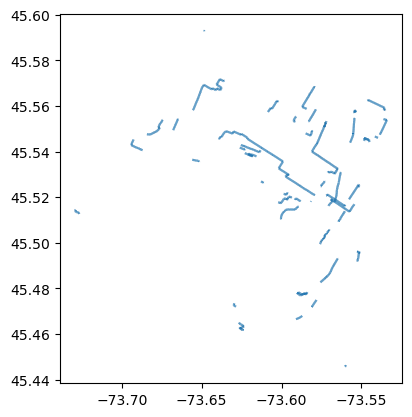

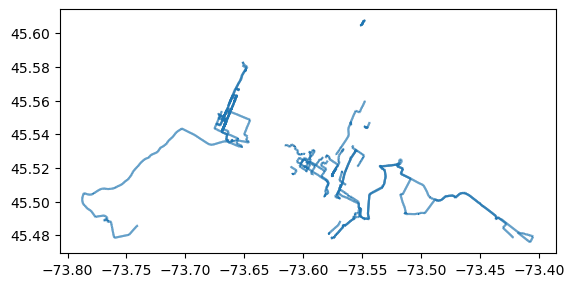

In [33]:
short_dt.plot()
long_dt.plot()
plt.show()

In [34]:
gdf.drop(columns=["dt_ind","dt_same", "vel_ind","vel_same"], inplace=True)

In [35]:
gdf.head(3)

stop  id_origine               start     length  \
trip_id ord                                                                  
0       1   2013-06-25 16:34:16          52 2013-06-25 16:21:21   3.259530   
        2   2013-06-25 16:34:16          52 2013-06-25 16:21:21  11.615175   
        3   2013-06-25 16:34:16          52 2013-06-25 16:21:21  14.267484   

             purpose  n_coord  id  duration  \
trip_id ord                                   
0       1    Commute      511  52     775.0   
        2    Commute      511  52     775.0   
        3    Commute      511  52     775.0   

                                                           geo  
trip_id ord                                                     
0       1    LINESTRING (-73.57748 45.50690, -73.57751 45.5...  
        2    LINESTRING (-73.57751 45.50692, -73.57757 45.5...  
        3    LINESTRING (-73.57757 45.50701, -73.57774 45.5...

In [36]:
#gdf_savepoint = gdf.copy()
#gdf = gdf_savepoint.copy()

## note on methods
Since alot of these values we want to add are the same for all points in a trip (mean length for example)
I've come up a way of only having to to the calculation once and then adding the value to all datapoints in the trip. 

I do it all the time, so I thought I'd explain the method once:
* create new column which will hold the value, set all elements to NaN
* "loc" onto all first elements in trip and assign the correct value: 
* use "forwardfill" to fill all later NaN-values with this value, until another "real" value shows up


To access a value with loc we can write
                
         gdf.loc[gdf.groupby(level=0).head(1).index]["mean"]
but to permanently assign the value we must write 
         
         gdf.loc[gdf.groupby(level=0).head(1).index, "mean"] = x

This will fill all NaN-values and "inplace=True" means that we do it permanently
            
         fillna(method="ffill", inplace=True)

## dt
We now have the dt which is duration/tot_coord
and can add time to all segments
It is important to remember that the time we add corresponds to THE LAST coordinate in segment
(all segments contains two coordinates: start and end of)
we:
* calculate the mean dt for all trips and set dt_tillf
* set dt to dt_tillf but in datetime
* find how much datetime the coordinate is from the start of the trip: "end_timestamp"
* let the time "t" of the point be start-time of trip + end_timestamp

we dont drop stuff just yet, because we will need them in a sec to take care of the first segment in each trip (remember, its starting point is actually the endpoint of the trip)

In [37]:
gdf["dt_tillf"] = ((gdf.groupby(level=0)["duration"].mean()).sum())/((gdf.groupby(level=0)["n_coord"].mean()).sum())

gdf["dt"] = gdf["dt_tillf"].apply(lambda x: timedelta(seconds=x))

gdf["end_timestamp"] = gdf.groupby(level=0, group_keys=False)["dt"].cumsum()
gdf.drop("dt_tillf", axis=1, inplace=True)

#timestamp AGAIN, FOR THE END COORDINATE OF THE SEGMENT
gdf["t"] = gdf["start"] + gdf["end_timestamp"]

## One idea is to cut up the trips
where we have any segments w/o gps.reading that are much longer than we expect.
Specifically longer than 38 meter (0.999 quantile) and reindex accordingly. \
\
The idea is to reconnect them (or their velocity data) after processing

In [105]:
gdf.reset_index(level=0, inplace=True)
lost_idx = gdf.columns[0]
gdf["long"] = 0
gdf.loc[gdf["length"]>= gdf["length"].quantile(0.999), "long"] = 1 
gdf["long"] = gdf["long"].cumsum()
gdf["trajectory_id"] = gdf[lost_idx] + gdf["long"]

gdf.set_index(["trajectory_id"], append=True, drop=False, inplace=True)
gdf = gdf.swaplevel().copy()

gdf["long"] = 0
gdf.loc[gdf["length"]>= gdf["length"].quantile(0.999), "long"] = np.nan
gdf.dropna(inplace=True)
gdf.drop(columns=[lost_idx, "long"], inplace=True)

In [52]:
# We go from around 5000 trips ("id_origine") to around 9000 "trips" ("trajectory_id")
gdf.head(3)

stop  id_origine               start  \
trajectory_id ord                                                       
0             1   2013-06-25 16:34:16          52 2013-06-25 16:21:21   
              2   2013-06-25 16:34:16          52 2013-06-25 16:21:21   
              3   2013-06-25 16:34:16          52 2013-06-25 16:21:21   

                      length  purpose  n_coord  id  duration  \
trajectory_id ord                                              
0             1     3.259530  Commute      511  52     775.0   
              2    11.615175  Commute      511  52     775.0   
              3    14.267484  Commute      511  52     775.0   

                                                                 geo  \
trajectory_id ord                                                      
0             1    LINESTRING (-73.57748 45.50690, -73.57751 45.5...   
              2    LINESTRING (-73.57751 45.50692, -73.57757 45.5...   
              3    LINESTRING (-73.57757 45.50701, -73.57774 45.5...   

                                      dt          end_timestamp  \
trajectory_id ord                                                 
0             1   0 days 00:00:01.172502 0 days 00:00:01.172502   
              2   0 days 00:00:01.172502 0 days 00:00:02.345004   
              3   0 days 00:00:01.172502 0 days 00:00:03.517506   

                                           t  trajectory_id  
trajectory_id ord                                            
0             1   2013-06-25 16:21:22.172502              0  
              2   2013-06-25 16:21:23.345004              0  
              3   2013-06-25 16:21:24.517506              0

# Now, unfortunately the Kalmanfilter needs point-geometry 
We will add an index to each trip which is the starting-point ("t"="start")
this needs to be handled separately because this coord should be the first in the segment after

In [53]:
#Copy all first points
gdf_test= gdf.copy()
gdf_head = gdf_test.groupby(level=0).head(1).copy()

#change timestamps
gdf_head["end_timestamp"] = timedelta(seconds=0)
gdf_head["t"] = gdf_head["start"]
#set the segment to a line between start and start-point (so that x[0].coords[1] = x[1].coords[0])
gdf_head["geo"] = gdf_head["geo"].apply(lambda x: LineString([Point(x.coords[0]), Point(x.coords[0])]))
gdf_head["length"] = 0
#Change indexing so concat works
idx_name = gdf_test.reset_index(level=1).columns[0]
gdf_head[idx_name] = [0 for x in range(len(gdf_head))]

gdf_head.reset_index(level=1,drop=True,inplace=True)
gdf_head.set_index(idx_name, append=True,inplace=True)
##concat (add) the two df together, and sort index
gdf_done = pd.concat([gdf_head.astype(gdf_test.dtypes), gdf_test])
gdf_done.sort_index(inplace=True)

In [54]:
gdf_done.head(3)

stop  id_origine               start  \
trajectory_id ord                                                       
0             0   2013-06-25 16:34:16          52 2013-06-25 16:21:21   
              1   2013-06-25 16:34:16          52 2013-06-25 16:21:21   
              2   2013-06-25 16:34:16          52 2013-06-25 16:21:21   

                      length  purpose  n_coord  id  duration  \
trajectory_id ord                                              
0             0     0.000000  Commute      511  52     775.0   
              1     3.259530  Commute      511  52     775.0   
              2    11.615175  Commute      511  52     775.0   

                                                                 geo  \
trajectory_id ord                                                      
0             0    LINESTRING (-73.57748 45.50690, -73.57748 45.5...   
              1    LINESTRING (-73.57748 45.50690, -73.57751 45.5...   
              2    LINESTRING (-73.57751 45.50692, -73.57757 45.5...   

                                      dt          end_timestamp  \
trajectory_id ord                                                 
0             0   0 days 00:00:01.172502        0 days 00:00:00   
              1   0 days 00:00:01.172502 0 days 00:00:01.172502   
              2   0 days 00:00:01.172502 0 days 00:00:02.345004   

                                           t  trajectory_id  
trajectory_id ord                                            
0             0   2013-06-25 16:21:21.000000              0  
              1   2013-06-25 16:21:22.172502              0  
              2   2013-06-25 16:21:23.345004              0

In [57]:
#Keep going
gdf = gdf_done.copy()

In [58]:
#create new column with last coord in segment as point
gdf["geometry"] = gdf["geo"].apply(lambda x: Point(x.coords[1]))

#change geom to point
gdf.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

In [59]:
gdf_done = gdf.copy() #SAVE HERE IF YOU MESS UP :)

In [60]:
gdf.drop(columns=["n_coord", "start", "stop", "end_timestamp"], inplace=True)

gdf["id"] = [x for x in range(len(gdf))]
gdf.set_index(["id"], inplace=True,
             append=True, drop=False)


In [61]:
gdf.reset_index(level=0,drop=True, inplace=True)
gdf.reset_index(level=0,drop=True, inplace=True)

### Current dataframe
* id: individual index
* id_origine: original trip index
* length: length from this point to the next one
* purpose: purpose of og trip
* duration: og duration
* geo: NOT GEOMETRY of dataframe but the linesegment from current point to next (this segment has length="length")
* dt: mean time (same for all)
* t: "actual" (approximated) time of recordning coordinate
* trajectory_id: index for this "trip" after cutting up some trips
* geometry: GEOMETRY of dataframe - point coordinate

In [62]:
gdf.head(3)

,id_origine,length,purpose,id,duration,geo,dt,t,trajectory_id,geometry
id,,,,,,,,,,
0,52,0.000000,Commute,0,775.0,"LINESTRING (-73.57748 45.50690, -73.57748 45.5...",0 days 00:00:01.172502,2013-06-25 16:21:21.000000,0,POINT (-73.57748 45.50690)
1,52,3.259530,Commute,1,775.0,"LINESTRING (-73.57748 45.50690, -73.57751 45.5...",0 days 00:00:01.172502,2013-06-25 16:21:22.172502,0,POINT (-73.57751 45.50692)
2,52,11.615175,Commute,2,775.0,"LINESTRING (-73.57751 45.50692, -73.57757 45.5...",0 days 00:00:01.172502,2013-06-25 16:21:23.345004,0,POINT (-73.57757 45.50701)


## Save point

In [63]:
gdf.to_csv('gdf_beforeKM.csv')

## Read from save-point

In [3]:
gdf = pd.read_csv('gdf_beforeKM.csv')
gdf.drop("id.1", axis=1, inplace=True)
gdf = gpd.GeoDataFrame(gdf)
gdf["geometry"] = gdf['geometry'].apply(wkt.loads)

gdf.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

In [4]:
gdf

,id,id_origine,length,purpose,duration,geo,dt,t,trajectory_id,geometry
0,0,52,0.000000,Commute,775.0,"LINESTRING (-73.577476909289 45.5069002299392,...",0 days 00:00:01.172502,2013-06-25 16:21:21.000000,0,POINT (-73.57748 45.50690)
1,1,52,3.259530,Commute,775.0,"LINESTRING (-73.577476909289 45.5069002299392,...",0 days 00:00:01.172502,2013-06-25 16:21:22.172502,0,POINT (-73.57751 45.50692)
2,2,52,11.615175,Commute,775.0,LINESTRING (-73.57751043029521 45.506916942621...,0 days 00:00:01.172502,2013-06-25 16:21:23.345004,0,POINT (-73.57757 45.50701)
3,3,52,14.267484,Commute,775.0,LINESTRING (-73.57756999999999 45.507011000001...,0 days 00:00:01.172502,2013-06-25 16:21:24.517506,0,POINT (-73.57774 45.50705)
4,4,52,21.120836,Commute,775.0,"LINESTRING (-73.577742 45.5070480000019, -73.5...",0 days 00:00:01.172502,2013-06-25 16:21:25.690008,0,POINT (-73.57792 45.50718)
...,...,...,...,...,...,...,...,...,...,...
4305647,4305647,28938,6.976099,Magasinage,102.0,"LINESTRING (-73.5447150004 45.5415695161019, -...",0 days 00:00:01.172502,2015-08-31 14:47:39.315108,9182,POINT (-73.54475 45.54151)
4305648,4305648,28938,8.120286,Magasinage,102.0,"LINESTRING (-73.5447533895 45.5415138603019, -...",0 days 00:00:01.172502,2015-08-31 14:47:40.487610,9182,POINT (-73.54478 45.54145)
4305649,4305649,28938,8.767340,Magasinage,102.0,"LINESTRING (-73.5447840673 45.5414451706019, -...",0 days 00:00:01.172502,2015-08-31 14:47:41.660112,9182,POINT (-73.54482 45.54137)
4305650,4305650,28938,7.957226,Magasinage,102.0,"LINESTRING (-73.5448186007 45.5413713260019, -...",0 days 00:00:01.172502,2015-08-31 14:47:42.832614,9182,POINT (-73.54486 45.54131)


In [65]:
# IF you do not read from save-point run the following two lines

#gdf.drop(columns=["id"],inplace=True)
#gdf.reset_index(level=0, drop=False,inplace=False)

In [66]:
gdf.head(2)

,id,id_origine,length,purpose,duration,geo,dt,t,trajectory_id,geometry
0,0,52,0.00000,Commute,775.0,"LINESTRING (-73.577476909289 45.5069002299392,...",0 days 00:00:01.172502,2013-06-25 16:21:21.000000,0,POINT (-73.57748 45.50690)
1,1,52,3.25953,Commute,775.0,"LINESTRING (-73.577476909289 45.5069002299392,...",0 days 00:00:01.172502,2013-06-25 16:21:22.172502,0,POINT (-73.57751 45.50692)


# So far the only thing we have done with the data is to decide how to interpret the size of the timestep.
This is not unimportant and will effect the data alot
but still, most of the code above is just reading and parsing data.

# KalmanFilter

In [67]:
mpd.show_versions()


MovingPandas 0.17.2

SYSTEM INFO
-----------
python     : 3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:35:41)  [Clang 16.0.6 ]
executable : /Users/johannaskantorp/anaconda3/envs/myenv/bin/python
machine    : macOS-14.2.1-arm64-arm-64bit

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.2
GDAL data dir: /Users/johannaskantorp/anaconda3/envs/myenv/share/gdal
PROJ       : 9.3.1
PROJ data dir: /Users/johannaskantorp/anaconda3/envs/myenv/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.14.3
pandas     : 2.1.1
fiona      : 1.9.5
numpy      : 1.26.3
shapely    : 2.0.1
rtree      : 1.0.1
pyproj     : 3.6.1
matplotlib : 3.8.3
mapclassify: 2.5.0
geopy      : 2.4.1
holoviews  : 1.18.3
hvplot     : 0.9.2
geoviews   : None
stonesoup  : None


## First we smooth with three different process noise std's
And this would take so long we only do it to the first 1000 trips in the dataset
\
## Save point 

In [59]:
gdf_std = gdf.loc[gdf["trajectory_id"]<=1000].copy()

t = time.time()

tc_t = mpd.TrajectoryCollection(gdf_std, 'trajectory_id', t='t')
print("Making the gdf a TrajectoryCollection takes", round(time.time()-t), "seconds")
stds = [0.1,0.3,0.5]
filename = ["smooth1000_01.csv", "smooth1000_03.csv","smooth1000_05.csv"]
gdfs = []

for i in range(len(stds)):
    std = stds[i]
    name = filename[i]
    
    smooth_t = mpd.KalmanSmootherCV(tc_t).smooth(process_noise_std=std, measurement_noise_std=10)
    smooth_t.add_speed()
    frame = smooth_t.to_point_gdf()
    frame.to_csv(name)
    gdfs.append(smooth_t.to_point_gdf())
    print("Finished with std", std, "total time:", round(time.time()-t), "seconds")
tc_t.add_speed()

Making the gdf a TrajectoryCollection takes 16 seconds
Finished with std 0.1 total time: 2340 seconds
Finished with std 0.3 total time: 4188 seconds
Finished with std 0.5 total time: 6034 seconds


In [60]:
frame = tc_t.to_point_gdf()

frame.to_csv("tc_1000.csv")
gdfs.append(frame)

## Read saved data

In [181]:
filenames = ["smooth1000_01.csv", "smooth1000_03.csv","smooth1000_05.csv", "tc_1000.csv"]
gdfs = []
stds = [0.1,0.3,0.5]

for file in filenames:
    frame = pd.read_csv(file)
    gdfs.append(frame)

# compare smoothing
"gdfs" contain the above

Here we need to test, and make a decision which parameters to choose. 
Still to be done!

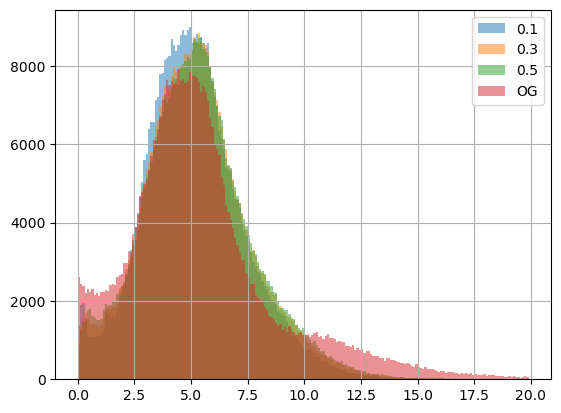

In [184]:
label = [str(x) for x in stds] + ["OG"]

for i in range(len(gdfs)):
    frame = gdfs[i]
    
    frame["speed"].hist(bins=[x*0.1 for x in range(200)], label=label[i], alpha = 0.5)
    
plt.legend()
plt.show()

# Make a decicion on which to use
Again, needs to be motivated,
currently running with: 
* process_noise_std=2.5, 
* measurement_noise_std=10

In [5]:
gdf_test = gdf.loc[gdf["trajectory_id"]<=2].copy() #gdf.copy()#gdf.loc[gdf["trajectory_id"]<=1000].copy()
gdf_test.drop(columns=["geo"], inplace=True)

In [7]:
gdf_test

,id,id_origine,length,purpose,duration,dt,t,trajectory_id,geometry
0,0,52,0.000000,Commute,775.0,0 days 00:00:01.172502,2013-06-25 16:21:21.000000,0,POINT (-73.57748 45.50690)
1,1,52,3.259530,Commute,775.0,0 days 00:00:01.172502,2013-06-25 16:21:22.172502,0,POINT (-73.57751 45.50692)
2,2,52,11.615175,Commute,775.0,0 days 00:00:01.172502,2013-06-25 16:21:23.345004,0,POINT (-73.57757 45.50701)
3,3,52,14.267484,Commute,775.0,0 days 00:00:01.172502,2013-06-25 16:21:24.517506,0,POINT (-73.57774 45.50705)
4,4,52,21.120836,Commute,775.0,0 days 00:00:01.172502,2013-06-25 16:21:25.690008,0,POINT (-73.57792 45.50718)
...,...,...,...,...,...,...,...,...,...
1334,1334,2326,2.270854,Courses,1437.0,0 days 00:00:01.172502,2013-07-25 14:35:52.799202,2,POINT (-73.58463 45.53236)
1335,1335,2326,1.388157,Courses,1437.0,0 days 00:00:01.172502,2013-07-25 14:35:53.971704,2,POINT (-73.58461 45.53235)
1336,1336,2326,0.137869,Courses,1437.0,0 days 00:00:01.172502,2013-07-25 14:35:55.144206,2,POINT (-73.58462 45.53235)
1337,1337,2326,1.165341,Courses,1437.0,0 days 00:00:01.172502,2013-07-25 14:35:56.316708,2,POINT (-73.58463 45.53235)


In [11]:
std=2
tc = mpd.TrajectoryCollection(gdf_test, traj_id_col='trajectory_id', obj_id_col="id", t="t")
smooth = mpd.KalmanSmootherCV(tc).smooth(process_noise_std=std, measurement_noise_std=10)
smooth.add_speed()

TypeError: __init__() got an unexpected keyword argument 't'

In [ ]:
tc.add_speed()
tc_save = tc.to_point_gdf()

In [ ]:
gm = smooth.to_point_gdf()

# Stops
we define a stop as not moving outside of a diameter of 30 meters in 20 seconds \
this might be a bad choice - look into further. \
We do this by creating a column which 
* = 1 if part of stop
* = 0 if not
* = 2 if lowest velocity in stopping period

In [8]:
detector = mpd.TrajectoryStopDetector(smooth)
stops = detector.get_stop_segments(min_duration=timedelta(seconds=20), max_diameter=30)
gdf_stops = stops.to_point_gdf()

In [10]:
but_point = gdf_stops.set_index(["trajectory_id"], inplace=False,
             append=True, drop=False).swaplevel().groupby(level=0)["speed"].idxmin().tolist()

In [11]:
cut_point = [x[1] for x in but_point]

In [12]:
gm["stop"] = 0
gm.loc[gdf_stops.index, "stop"] = 1
gm.loc[cut_point, "stop"] = 2

## save point
We save both the processed trips (gm) and the unprocessed trips (tc_save) \
tc_save is basically gdf, but in in the same "form" as gm (what movingpandas calls a trajectory-collection). But it's convenient that they are similar, so we use this instead of gdf going forward.

In [13]:
#gm.to_csv("gm_KM2_5.csv")
#tc_save.to_csv('OG_kf.csv')

# start from here

In [52]:
#gm = pd.read_csv('gm_kf.csv')
gm = pd.read_csv('gm_KM2_5.csv')
gm.set_index(["t"],inplace=True)
gm = gpd.GeoDataFrame(gm)
gm["geometry"] = gm['geometry'].apply(wkt.loads)
gm.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

In [40]:
tc_save = pd.read_csv('OG_kf.csv')
tc_save.set_index(["t"],inplace=True)
tc_save = gpd.GeoDataFrame(tc_save)
tc_save["geometry"] = tc_save['geometry'].apply(wkt.loads)
tc_save.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

Since the Kalman-filter only shifts the positions we expect these to be identical except for 
* geometry
* speed
* stop (which does not exist for tc_save)

In [54]:
tc_save

,og_idx,length,purpose,trajectory_id,duration,dt,geometry,id,vel,acc
t,,,,,,,,,,
2013-06-25 16:21:21.000000,0,0.000000,Commute,52,775.0,0 days 00:00:01.359649,POINT (-73.57748 45.50690),0,2.361878,-0.000000
2013-06-25 16:21:22.359649,0,3.259530,Commute,52,775.0,0 days 00:00:01.359649,POINT (-73.57751 45.50692),1,2.361878,6.054558
2013-06-25 16:21:23.719298,0,11.615175,Commute,52,775.0,0 days 00:00:01.359649,POINT (-73.57757 45.50701),2,8.416436,1.921885
2013-06-25 16:21:25.078947,0,14.267484,Commute,52,775.0,0 days 00:00:01.359649,POINT (-73.57774 45.50705),3,10.338321,4.965994
2013-06-25 16:21:26.438596,0,21.120836,Commute,52,775.0,0 days 00:00:01.359649,POINT (-73.57792 45.50718),4,15.304315,-1.983258
...,...,...,...,...,...,...,...,...,...,...
2015-08-31 14:34:18.995138,4871,6.144433,Aller au travail,28942,423.0,0 days 00:00:02.053398,POINT (-73.58132 45.52328),4304168,2.948295,-0.287479
2015-08-31 14:34:21.048536,4871,5.545309,Aller au travail,28942,423.0,0 days 00:00:02.053398,POINT (-73.58125 45.52327),4304169,2.660816,0.502372
2015-08-31 14:34:23.101934,4871,6.592285,Aller au travail,28942,423.0,0 days 00:00:02.053398,POINT (-73.58118 45.52323),4304170,3.163188,-0.157510


In [55]:
gm

,id,id_origine,length,purpose,duration,dt,trajectory_id,geometry,speed,stop
t,,,,,,,,,,
2013-06-25 16:21:22.172502,0,52,3.259530,Commute,775.0,0 days 00:00:01.172502,0,POINT (-73.57764 45.50701),3.017804,0
2013-06-25 16:21:23.345004,1,52,11.615175,Commute,775.0,0 days 00:00:01.172502,0,POINT (-73.57767 45.50703),3.017804,0
2013-06-25 16:21:24.517506,2,52,14.267484,Commute,775.0,0 days 00:00:01.172502,0,POINT (-73.57777 45.50708),8.149587,0
2013-06-25 16:21:25.690008,3,52,21.120836,Commute,775.0,0 days 00:00:01.172502,0,POINT (-73.57790 45.50716),11.506679,0
2013-06-25 16:21:26.862510,4,52,18.383815,Commute,775.0,0 days 00:00:01.172502,0,POINT (-73.57805 45.50725),12.814298,0
...,...,...,...,...,...,...,...,...,...,...
2015-08-31 14:47:39.315108,4297178,28938,6.976099,Magasinage,102.0,0 days 00:00:01.172502,9182,POINT (-73.54475 45.54150),5.692212,0
2015-08-31 14:47:40.487610,4297179,28938,8.120286,Magasinage,102.0,0 days 00:00:01.172502,9182,POINT (-73.54479 45.54144),5.857093,0
2015-08-31 14:47:41.660112,4297180,28938,8.767340,Magasinage,102.0,0 days 00:00:01.172502,9182,POINT (-73.54482 45.54139),5.890508,0


In [42]:
# just a safety measure
gm_savepoint = gm.copy()

### clean up
* rename "speed" to "vel" because I did not fully plan this code
* add "acc" = "diff in vel" (for now) 
* add and re-order index (for some reason reorder_levels does not have inplace)
* create time-columns for calculating actual acceleration
* compute acceleration (i.e. divide by time)
* NOTE: when we later "reattach" the trips there will be an odd "zero acceleration" at the junctions

In [56]:
gm.rename(columns={"speed":"vel"}, inplace=True)
tc_save.rename(columns={"speed":"vel"}, inplace=True)

In [57]:
gm["acc"] = -gm["vel"].diff(periods=-1)
tc_save["acc"] = -tc_save["vel"].diff(periods=-1)

In [63]:
gm.set_index(["trajectory_id"], inplace=True, append=True, drop=True)

In [64]:
gm.reorder_levels(["trajectory_id", "t"])

id  id_origine     length  \
trajectory_id t                                                            
0             2013-06-25 16:21:22.172502        0          52   3.259530   
              2013-06-25 16:21:23.345004        1          52  11.615175   
              2013-06-25 16:21:24.517506        2          52  14.267484   
              2013-06-25 16:21:25.690008        3          52  21.120836   
              2013-06-25 16:21:26.862510        4          52  18.383815   
...                                           ...         ...        ...   
9182          2015-08-31 14:47:39.315108  4297178       28938   6.976099   
              2015-08-31 14:47:40.487610  4297179       28938   8.120286   
              2015-08-31 14:47:41.660112  4297180       28938   8.767340   
              2015-08-31 14:47:42.832614  4297181       28938   7.957226   
              2015-08-31 14:47:44.005116  4297182       28938   2.979232   

                                             purpose  duration  \
trajectory_id t                                                  
0             2013-06-25 16:21:22.172502     Commute     775.0   
              2013-06-25 16:21:23.345004     Commute     775.0   
              2013-06-25 16:21:24.517506     Commute     775.0   
              2013-06-25 16:21:25.690008     Commute     775.0   
              2013-06-25 16:21:26.862510     Commute     775.0   
...                                              ...       ...   
9182          2015-08-31 14:47:39.315108  Magasinage     102.0   
              2015-08-31 14:47:40.487610  Magasinage     102.0   
              2015-08-31 14:47:41.660112  Magasinage     102.0   
              2015-08-31 14:47:42.832614  Magasinage     102.0   
              2015-08-31 14:47:44.005116  Magasinage     102.0   

                                                              dt  \
trajectory_id t                                                    
0             2013-06-25 16:21:22.172502  0 days 00:00:01.172502   
              2013-06-25 16:21:23.345004  0 days 00:00:01.172502   
              2013-06-25 16:21:24.517506  0 days 00:00:01.172502   
              2013-06-25 16:21:25.690008  0 days 00:00:01.172502   
              2013-06-25 16:21:26.862510  0 days 00:00:01.172502   
...                                                          ...   
9182          2015-08-31 14:47:39.315108  0 days 00:00:01.172502   
              2015-08-31 14:47:40.487610  0 days 00:00:01.172502   
              2015-08-31 14:47:41.660112  0 days 00:00:01.172502   
              2015-08-31 14:47:42.832614  0 days 00:00:01.172502   
              2015-08-31 14:47:44.005116  0 days 00:00:01.172502   

                                                            geometry  \
trajectory_id t                                                        
0             2013-06-25 16:21:22.172502  POINT (-73.57764 45.50701)   
              2013-06-25 16:21:23.345004  POINT (-73.57767 45.50703)   
              2013-06-25 16:21:24.517506  POINT (-73.57777 45.50708)   
              2013-06-25 16:21:25.690008  POINT (-73.57790 45.50716)   
              2013-06-25 16:21:26.862510  POINT (-73.57805 45.50725)   
...                                                              ...   
9182          2015-08-31 14:47:39.315108  POINT (-73.54475 45.54150)   
              2015-08-31 14:47:40.487610  POINT (-73.54479 45.54144)   
              2015-08-31 14:47:41.660112  POINT (-73.54482 45.54139)   
              2015-08-31 14:47:42.832614  POINT (-73.54486 45.54133)   
              2015-08-31 14:47:44.005116  POINT (-73.54489 45.54128)   

                                                vel  stop       acc  
trajectory_id t                                                      
0             2013-06-25 16:21:22.172502   3.017804     0 -0.000000  
              2013-06-25 16:21:23.345004   3.017804     0  5.131783  
              2013-06-25 16:21:24.517506   8.149587     0  3.357092  
              2013-06-25 16

In [67]:
gm.set_index(["trajectory_id"], inplace=True,
             append=True, drop=True)
gm = gm.reorder_levels(["trajectory_id", "t"]).copy()

tc_save.set_index(["trajectory_id"], inplace=True,
              append=True, drop=True)
tc_save = tc_save.reorder_levels(["trajectory_id", "t"]).copy()

In [68]:
#create a column which is dt but in seconds
gm["time"] = pd.to_timedelta(gm["dt"]).dt.total_seconds()

gm["timesum"] = gm.groupby(level=0)["time"].cumsum()


tc_save["time"] = pd.to_timedelta(tc_save["dt"]).dt.total_seconds()
tc_save["timesum"] = tc_save.groupby(level=0)["time"].cumsum()

In [69]:
# acceleration should be set to zero if we are at the end or beginning of a trajectory
gm.loc[gm.groupby("trajectory_id").tail(1).index, "acc"] = 0
tc_save.loc[tc_save.groupby("trajectory_id").tail(1).index, "acc"] = 0

In [70]:
gm["acc"] = gm["acc"]/gm["time"]
tc_save["acc"] = tc_save["acc"]/tc_save["time"]

# Elevation
This takes some time, and should not be done if we decide not to use

In [53]:
##Create a grid of all data-points available, with corresponding elevation.
##interp is now a function that we can put lat-long into and get the interpolated elevation in that point
lat = np.array(df_el["lat"].unique().tolist())
long = df_el["long"].unique().tolist()
xg, yg = np.meshgrid(lat, long, indexing='ij')

##1474 long append 1843 of them
elev = []
for i in range(1843):
    elev.append(df_el.loc[df_el["lat"]==(df_el["lat"][i])]["elevation"].tolist())



interp = RegularGridInterpolator((lat, long), elev,
                                 bounds_error=False, fill_value=None)

In [54]:
#we find the elevation of the FIRST coord [0] in the segment, so later, 
#if we want incline over segment we should compare it to the elevation in the NEXT row
#this is somewhat incorrect since we will have the geo in points.. change accordingly


coordinates = gm.geometry.apply(lambda x: np.array(x.coords[0]))
pts =  np.array(coordinates.tolist())

elevation_list = interp(pts)

gm["elev_start"] = elevation_list

In [55]:
coordinates = tc_save.geometry.apply(lambda x: np.array(x.coords[0]))
pts =  np.array(coordinates.tolist())

elevation_list = interp(pts)

tc_save["elev_start"] = elevation_list

In [ ]:
#gm["scaled_elev"] = gm["elev_start"]/10
#N = 9

#fig = plt.figure(figsize=(25, 5*round(N/3)))
#num = 5
#for i in range(N):
#    plt.subplot(round(N/3),3,i+1)
#    plt.xlabel("time")
#    plt.ylabel("elevation")
#    x = gm.groupby(level=0).get_group(i+num)["time_ind"].cumsum().tolist()
    plt.plot(x, gm.groupby(level=0).get_group(i+num)["vel_og"], alpha=0.5)
    y = gm.groupby(level=0).get_group(i+num)["scaled_elev"].tolist()
    x = [0] + x + [x[-1]]
    y = [0] + y + [0]
    plt.plot(x, y, color="red")
    plt.fill(x, y,[0 for y in x], color="red", alpha = 0.3)
    #section = np.arange(-1, 1, 1/20.)
    #plt.fill_between(section,f(section))
    #plt.plot([1,2,3], [1,2,3], "-")
    #plt.xlim([0, 1000])
    plt.ylim([0,20])
    #plt.title("trip #"+str(trip))

plt.show()

## End of elevation (for now)

In [56]:
#gdf_save1 = gdf.copy()

#gm.to_csv('gm_elev_KM03.csv')
#tc_save.to_csv("tc_elev_collection.csv")

#gdf = pd.read_csv('gdf_firstsave.csv')
#gdf.set_index(["t"],inplace=True)
#gdf = gpd.GeoDataFrame(gdf)
#gdf["geometry"] = gdf['geometry'].apply(wkt.loads)

#gdf.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

# Done

Meet your dataframe:
Currently it consists of 
* trip index (level=0)
* segment index (level=1)
* purpose of trip
* duration; [s] according to og data 
* dt; time for segment in datetime (all the same)
* geometry; point geometry
* id; relic of kalmanfilter
* length; [m] length of linesegment: NO LONGER TRUE AFTER SMOOTHING (True for tc_save)
* vel; [m/s] vel after smoothing
* stop; 1 if point is part of a stop, 0 else, 2 if cutting point
* time; mean time between GPS readings



* elev; [m] elevation in first point of linestring/point geom

In [27]:
gm.groupby(level=0).head(1).index

MultiIndex([(   0, '2013-06-25 16:21:22.172502'),
            (   1, '2013-07-25 14:37:43.172502'),
            (   2, '2013-07-25 14:19:16.172502'),
            (   3, '2013-06-25 16:21:21.172502'),
            (   4, '2013-06-25 16:22:38.557634'),
            (   5, '2013-06-26 12:46:02.172502'),
            (   6, '2013-06-26 12:58:11.468746'),
            (   7, '2013-07-02 12:21:57.172502'),
            (   8, '2013-07-02 12:05:49.172502'),
            (   9, '2013-07-02 12:12:25.478178'),
            ...
            (9171, '2015-08-26 09:16:30.090488'),
            (9172, '2015-08-29 15:10:52.172502'),
            (9173, '2015-08-30 13:05:29.172502'),
            (9174, '2015-07-04 17:10:46.172502'),
            (9175, '2015-08-29 17:28:12.172502'),
            (9176, '2015-08-29 17:30:30.527738'),
            (9177, '2015-08-30 15:40:31.172502'),
            (9178, '2015-08-30 15:42:41.320224'),
            (9180, '2015-08-30 19:35:19.172502'),
            (9182, '2015-08-31 14:

## Let's put the trips back together
The only reason we cut them was to not give any weigth to the segments where we lost contact, but there are some other issues instead:
* The kalman filter will always assume we start at zero. Which means we will get some weird behaviour around where we reattach the trajectories into trips.
* To avoid this we could cut away around the first half minute of all trajectories.
* The mean time before we get our first deceleration is 26 seconds, which would indicate that this is what movingpandas considers the "upstart" time
* On the other hand.. Maybe there is a better idea.
* Currently we cut the first 26 seconds or efter the first deceleration
* but Im open to suggestions

In [72]:
#gm[["vel", "acc"]].xs(114).head(10)

9.417843411720227

In [71]:
cut = gm.loc[gm["acc"]<-0.000000001].groupby("trajectory_id").head(1)["timesum"].mean()

In [73]:
gm["drop"] = np.nan #create temporary col and set all to nan
gm.loc[gm["timesum"]>cut, "drop"] = 1 #if later than 26 second into trip - NOT nan
gm.loc[gm["acc"]<-0.000000001, "drop"] = 1 # if accel < 0 NOT nan
gm["drop"] = gm.groupby(level=0)["drop"].cumsum() # now if something (in the trajectoryu) comes AFTER a 1 (i.e. not nan) it will no longer be nan


tc_save["drop"] = gm["drop"] # delete corresponding from tc_save - MAYBE NOT???

tc_save.dropna(inplace=True) #drop these
gm.dropna(inplace=True)

#delete temporary column
gm.drop("drop", axis=1, inplace=True)
tc_save.drop("drop", axis=1, inplace=True)

In [74]:
gm.groupby("id_origine").head(1)

,,id,id_origine,length,purpose,duration,dt,geometry,vel,stop,acc,time,timesum
trajectory_id,t,,,,,,,,,,,,
0,2013-06-25 16:21:26.862510,4,52,18.383815,Commute,775.0,0 days 00:00:01.172502,POINT (-73.57805 45.50725),12.814298,0,-0.436593,1.172502,5.862510
1,2013-07-25 14:37:46.690008,409,2325,3.384956,Courses,144.0,0 days 00:00:01.172502,POINT (-73.62889 45.46379),1.103268,0,-0.030382,1.172502,4.690008
2,2013-07-25 14:19:25.552518,489,2326,10.261117,Courses,1437.0,0 days 00:00:01.172502,POINT (-73.58188 45.56567),8.170779,0,0.260488,1.172502,10.552518
3,2013-06-25 16:21:28.207514,1342,53,9.555757,Commute,776.0,0 days 00:00:01.172502,POINT (-73.57797 45.50719),8.161723,0,-0.211601,1.172502,8.207514
5,2013-06-26 12:46:11.552518,1696,56,5.878582,Domicile-travail,844.0,0 days 00:00:01.172502,POINT (-73.60453 45.51897),4.973381,0,-0.019674,1.172502,10.552518
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9174,2015-07-04 17:10:55.552518,4295950,28853,5.201153,other,526.0,0 days 00:00:01.172502,POINT (-73.61819 45.53783),6.804059,0,0.888706,1.172502,10.552518
9175,2015-08-29 17:28:21.552518,4296209,28859,3.040028,Travail,328.0,0 days 00:00:01.172502,POINT (-73.66583 45.54811),7.073760,0,0.242165,1.172502,10.552518
9177,2015-08-30 15:40:38.207514,4296379,28893,6.121290,Magasinage,2161.0,0 days 00:00:01.172502,POINT (-73.58108 45.52610),2.201425,0,-0.070220,1.172502,8.207514


# Now we want to change back to the original index 

In [75]:
gm.set_index("id_origine", inplace=True, append=True, drop=False)
gm.reset_index("trajectory_id", inplace=True)
gm = gm.reorder_levels(["id_origine", "t"]).copy()

In [76]:
gm["timesum"] = gm.groupby(level=0)["time"].cumsum()
gm["timesum"] = gm["timesum"] - gm["time"]
#set all to NaN
gm["duration"] = np.nan
#set last elem in group to its timesum-value = the duration of this MT
gm.loc[gm.groupby(level=0).tail(1).index, "duration"] = gm.groupby(level=0).tail(1)["timesum"].tolist()
gm["duration"].fillna(method="bfill",inplace=True)

In [21]:
tc_save.set_index("og_idx", inplace=True, append=True, drop=False)
tc_save.reset_index("trajectory_id", inplace=True)
tc_save = tc_save.reorder_levels(["og_idx", "t"]).copy()
tc_save["timesum"] = tc_save.groupby(level=0)["time"].cumsum()
tc_save["timesum"] = tc_save["timesum"] - tc_save["time"]
#set all to NaN
tc_save["duration"] = np.nan
#set last elem in group to its timesum-value = the duration of this MT
tc_save.loc[tc_save.groupby(level=0).tail(1).index, "duration"] = tc_save.groupby(level=0).tail(1)["timesum"].tolist()
tc_save["duration"].fillna(method="bfill",inplace=True)

## Save point

In [77]:
#gm.to_csv("gm_part1.csv")
gm.to_csv("gm_part1_b.csv")

In [22]:
tc_save.to_csv("tc_save_part1.csv")

## Go to stat_part2